# SAE weights

In [1]:
import os
from copy import deepcopy

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from safetensors.torch import load_file
from sae.sae import EncoderOutput

Triton not installed, using eager implementation of SAE decoder.


In [2]:
path = "weights2weights/weights_datasets"
device = "cuda"

In [3]:
from sae import Sae
# sae_path = "runs/test1/0"
# sae_path = "runs/run_lat5000_bs256_auxk0.03_k1000/0"
sae_path = "runs/test_feature_logging/0"
sae = Sae.load_from_disk(sae_path,device=device)
sae.eval()

Sae(
  (encoder): Linear(in_features=99648, out_features=5000, bias=True)
)

In [4]:
sae.W_dec.shape

torch.Size([5000, 99648])

In [5]:
sae.b_dec.shape

torch.Size([99648])

In [6]:
W = sae.W_dec

In [7]:
c = W[0]
c.shape

torch.Size([99648])

In [8]:
threshold =  c.shape[0] - int(c.shape[0] * 0.7)
threshold

29895

## Normalize

In [8]:
min_ = W.min()
max_ = W.max()
resc = (W - min_)/(max_ - min_)

In [9]:
resc.min(), resc.max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1., device='cuda:0', grad_fn=<MaxBackward1>))

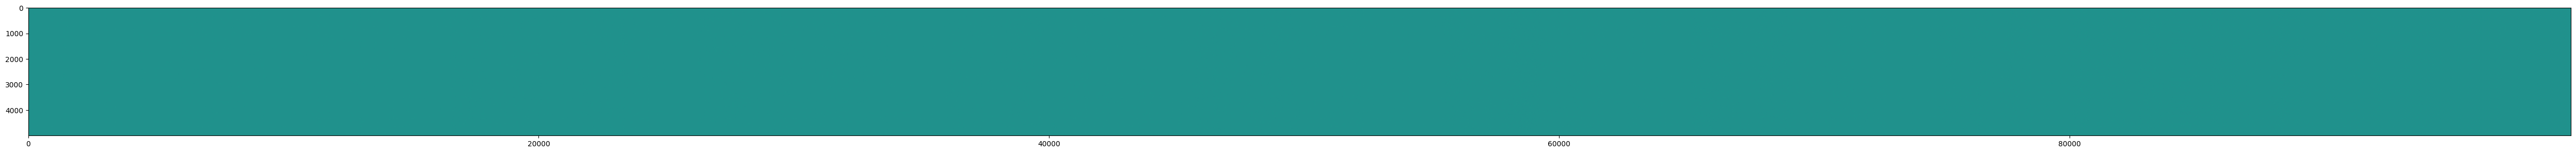

In [10]:
fig, ax = plt.subplots(figsize=(50, 30))
im = ax.imshow(resc.cpu().detach().numpy())
fig.tight_layout()
plt.show()

## Find epsilon

In [9]:
eps = W.abs().max().item() * 1e-1
eps

0.007147854566574097

In [10]:
(W.abs() > eps).sum(dim=0)

tensor([413, 314, 580,  ...,   0,   2,   0], device='cuda:0')

In [11]:
W.numel()

498240000

In [12]:
W.dtype

torch.float32

In [13]:
W.abs().min(), W.abs().mean(), W.mean()

(tensor(9.7594e-13, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-5.1741e-07, device='cuda:0', grad_fn=<MeanBackward0>))

In [14]:
W.abs().std(), W.std()

(tensor(0.0021, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.0032, device='cuda:0', grad_fn=<StdBackward0>))

In [15]:
e = W.abs().max().item()
scale = [1e-6, 1e-4,1e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]
for s in scale:
    num_nonzero = (W.abs() > e*s).sum().item()
    print(f"Epsilon = {e*s:.2e}, Nonzero Elements %: {num_nonzero/W.numel()*100:.2f}")

Epsilon = 7.15e-08, Nonzero Elements %: 100.00
Epsilon = 7.15e-06, Nonzero Elements %: 99.77
Epsilon = 7.15e-05, Nonzero Elements %: 97.69
Epsilon = 3.57e-04, Nonzero Elements %: 88.58
Epsilon = 7.15e-04, Nonzero Elements %: 77.84
Epsilon = 1.43e-03, Nonzero Elements %: 59.31
Epsilon = 3.57e-03, Nonzero Elements %: 23.16
Epsilon = 7.15e-03, Nonzero Elements %: 3.09


In [16]:
hist_counts, bin_edges = torch.histogram(W.cpu(), bins=100)

# Convert small results to NumPy for plotting
hist_counts = hist_counts.cpu().detach().numpy()
bin_edges = bin_edges.cpu().detach().numpy()

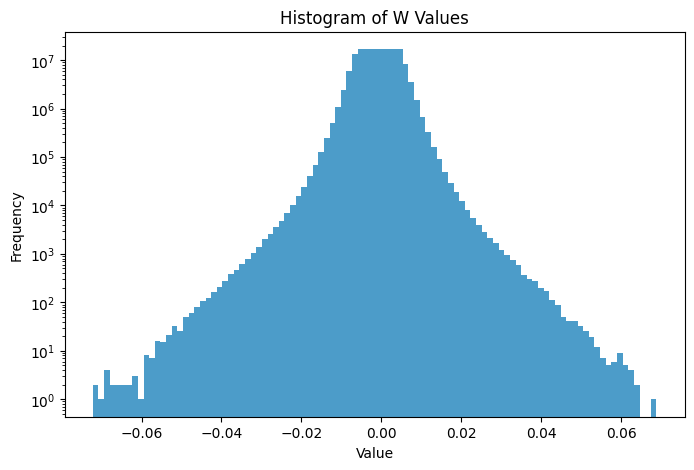

In [17]:
# Plot
plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1], hist_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Histogram of W Values")
plt.show()

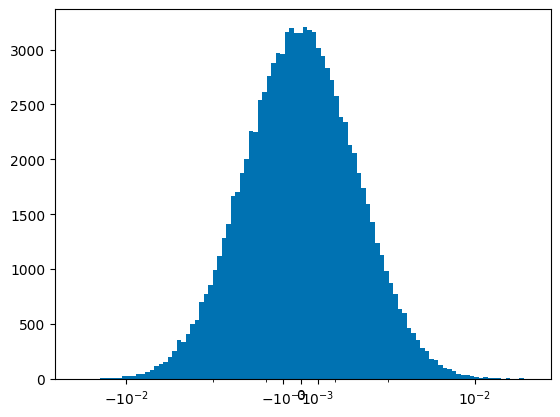

In [18]:
plt.hist(W[0].cpu().detach().numpy(), bins=100)
plt.xscale("asinh")
plt.show()

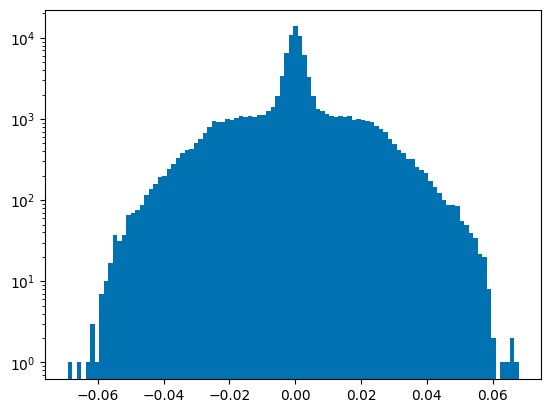

In [19]:
plt.hist(sae.b_dec.cpu().detach().numpy(), bins=100)
# plt.xscale("asinh")
plt.yscale("log")
plt.show()

In [20]:
W_half = W.to(torch.float16)

In [21]:
(W_half == 0).sum()/W.numel()*100

tensor(0.0010, device='cuda:0')

In [22]:
W_half.abs().min()

tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>)

In [23]:
smallest = W_half.abs().min()
second_smallest = W_half.abs()[W_half.abs() > smallest].min()  # Find next smallest
print(smallest, second_smallest)

tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>) tensor(5.9605e-08, device='cuda:0', dtype=torch.float16,
       grad_fn=<MinBackward1>)


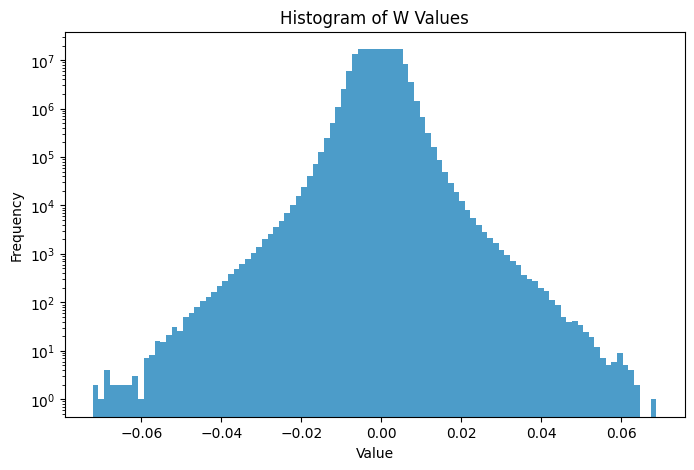

In [24]:
hist_counts, bin_edges = torch.histogram(W_half.to(torch.float32).cpu(), bins=100)

# Convert small results to NumPy for plotting
hist_counts = hist_counts.cpu().detach().numpy()
bin_edges = bin_edges.cpu().detach().numpy()
# Plot
plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1], hist_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Histogram of W Values")
plt.show()

!!! Careful with columns vs rows

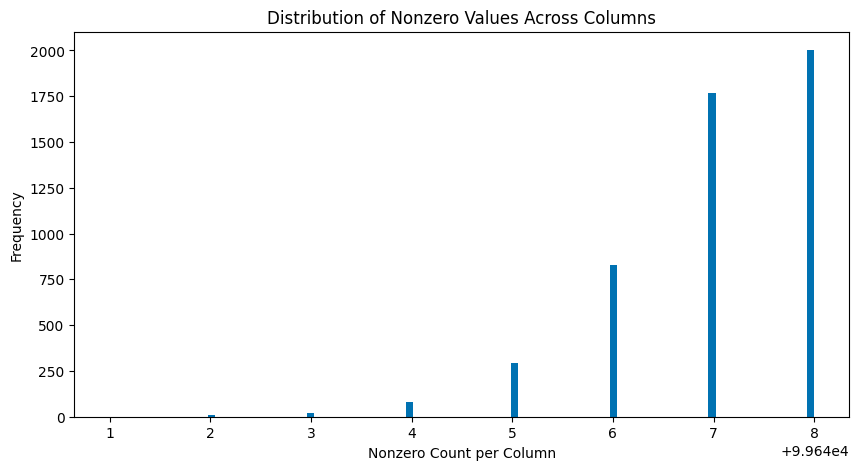

In [25]:
nonzero_counts = (W_half != 0).sum(dim=1).cpu().numpy()  # Count nonzero values per column
plt.figure(figsize=(10, 5))
plt.hist(nonzero_counts, bins=100, log=False)  # Log scale to see details
plt.xlabel("Nonzero Count per Column")
plt.ylabel("Frequency")
plt.title("Distribution of Nonzero Values Across Columns")
plt.show()

## Find sparse

In [26]:
((W_half >= eps*1) | (W_half <= eps*-1)).sum(dim=1).shape  # number of nonzero elementd for column corresponding to feature

torch.Size([5000])

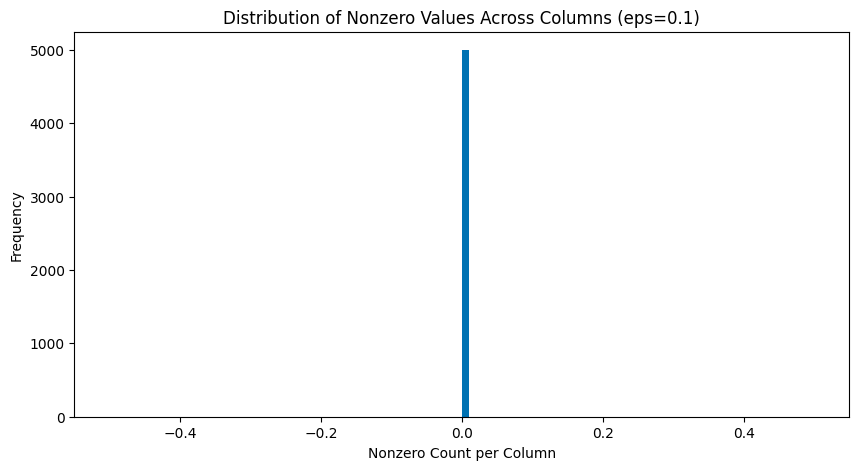

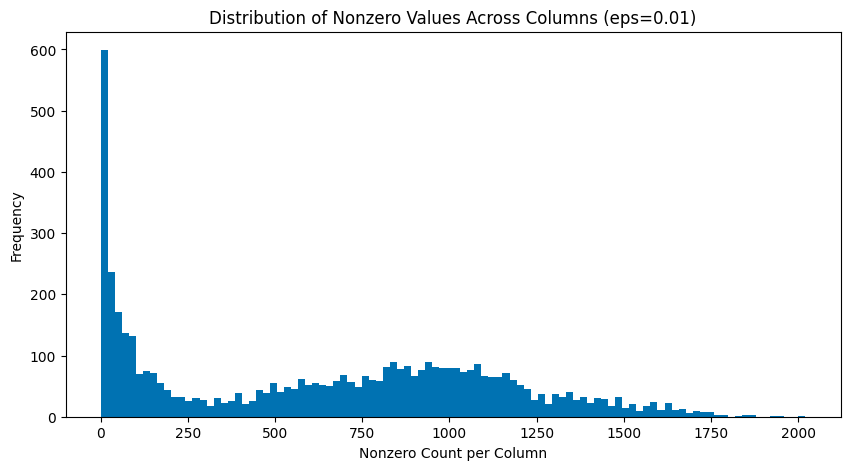

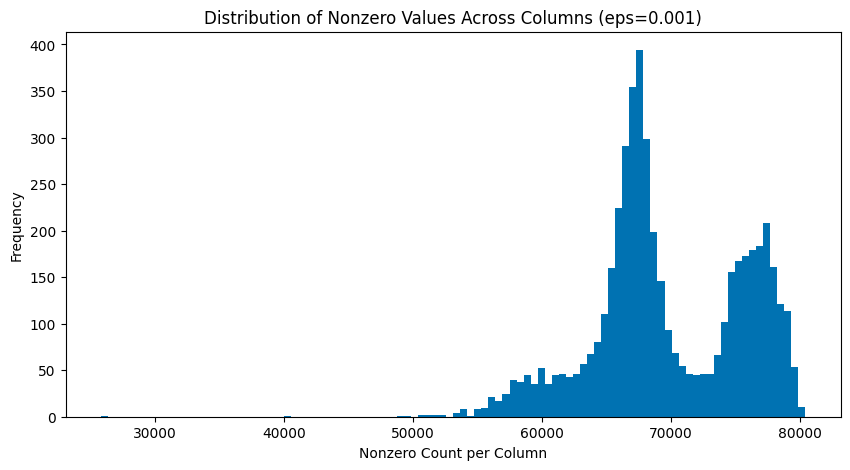

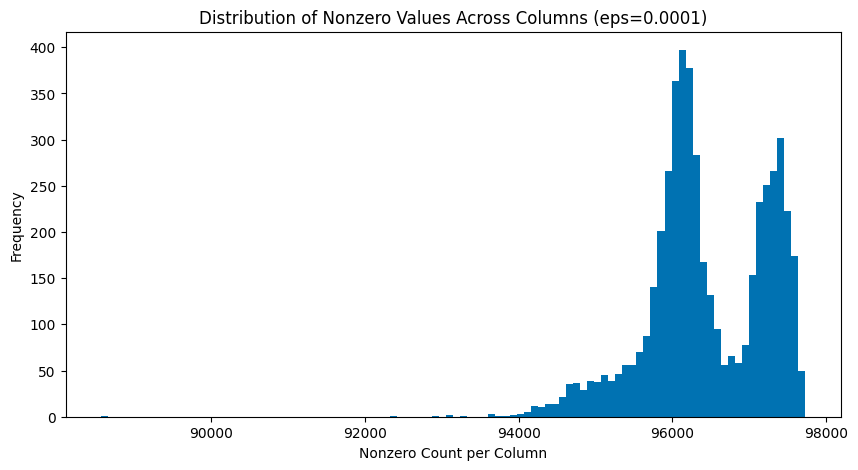

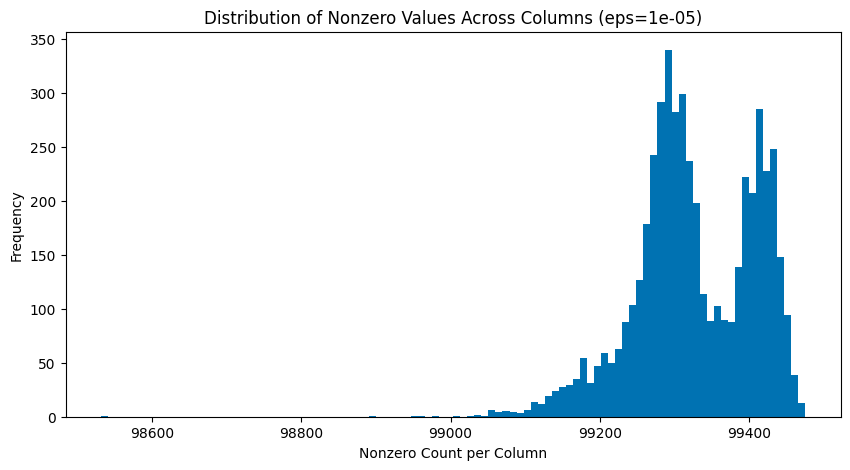

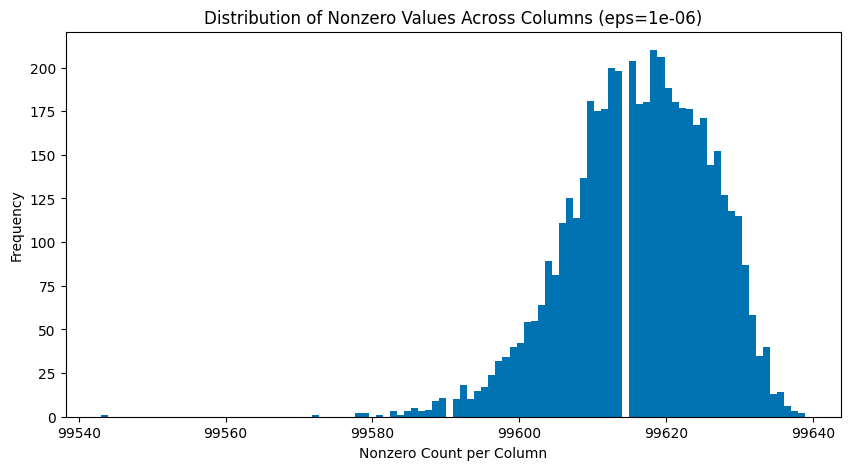

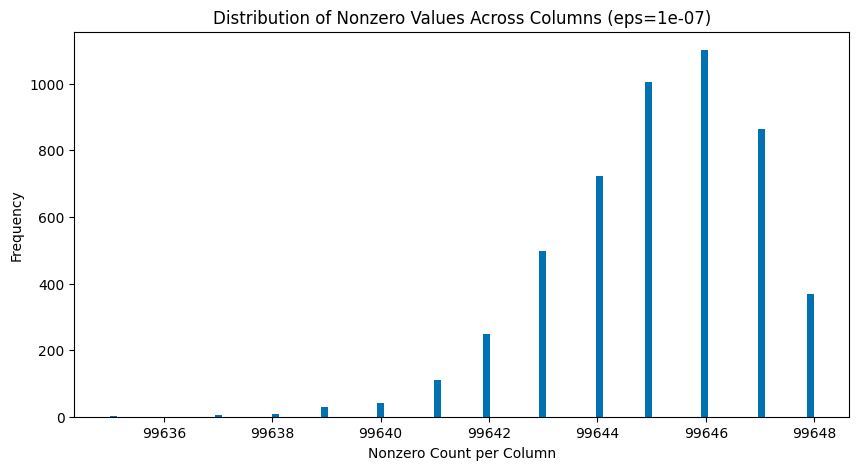

In [27]:
for i in range(7):
    eps = eval(f"1e-{i+1}")
    nonzero_counts = ((W_half >= eps*1) | (W_half <= eps*-1)).sum(dim=1).cpu().numpy()  # Count nonzero values per column
    plt.figure(figsize=(10, 5))
    plt.hist(nonzero_counts, bins=100, log=False)  # Log scale to see details
    plt.xlabel("Nonzero Count per Column")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Nonzero Values Across Columns (eps={eps})")
    plt.show()

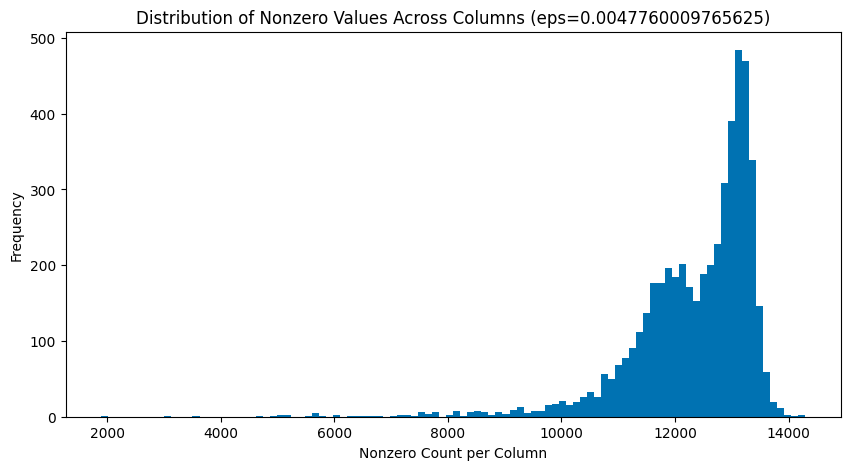

In [28]:
eps = W_half.abs().mean()*2
nonzero_counts = ((W_half >= eps*1) | (W_half <= eps*-1)).sum(dim=1).cpu().numpy()  # Count nonzero values per column
plt.figure(figsize=(10, 5))
plt.hist(nonzero_counts, bins=100, log=False)  # Log scale to see details
plt.xlabel("Nonzero Count per Column")
plt.ylabel("Frequency")
plt.title(f"Distribution of Nonzero Values Across Columns (eps={eps})")
plt.show()

In [29]:
sparse_threshold = 10000  # Adjust as needed
sparse_cols = (nonzero_counts < sparse_threshold).nonzero()[0]
print(f"Found {len(sparse_cols)} sparse columns.")

Found 167 sparse columns.


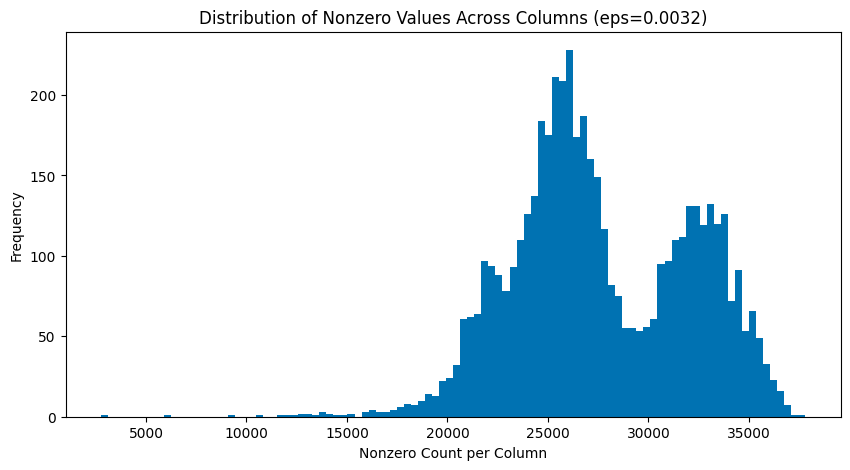

In [30]:
eps = 0.0032
nonzero_counts = ((W_half >= eps*1) | (W_half <= eps*-1)).sum(dim=1).cpu().numpy()  # Count nonzero values per column
plt.figure(figsize=(10, 5))
plt.hist(nonzero_counts, bins=100, log=False)  # Log scale to see details
plt.xlabel("Nonzero Count per Column")
plt.ylabel("Frequency")
plt.title(f"Distribution of Nonzero Values Across Columns (eps={eps})")
plt.show()

In [31]:
sparse_threshold = threshold  # Adjust as needed
sparse_cols = (nonzero_counts < sparse_threshold).nonzero()[0]
print(f"Found {len(sparse_cols)} sparse columns.")

Found 3325 sparse columns.


## Calculate norms

In [9]:
import pandas as pd
d = torch.load(f"{path}/weight_dimensions.pt")
dim_df = pd.DataFrame(d).T
# dim_df


In [10]:
dim_df["lengths"] = [a.numel() for a,_ in list(d.values())]
dim_df["start"] = dim_df.lengths.cumsum().shift(fill_value=0)
dim_df["end"] = dim_df.start + dim_df.lengths
# dim_df

In [ ]:
dim_df["block_type"] = dim_df.index.str.extract(r"(down_blocks|up_blocks)")[0].fillna("mid_block").values
dim_df["block_number"] = dim_df.index.str.extract(r"(?:down_blocks|up_blocks)\.(\d+)")[0].fillna("0").values

In [12]:
dim_df["attentions_number"] = dim_df.index.str.extract(r"attentions\.(\d+)")[0].values
dim_df["attn_number"] = dim_df.index.str.extract(r"attn(\d+)")[0].values
dim_df["attn_proj"] = dim_df.index.str.extract(r"attn\d+\.(to_[qvkout]+)")[0].values
dim_df["lora_ab"] = dim_df.index.str.extract(r"lora_([AB])")[0].values

In [13]:
dim_df

,0,1,lengths,start,end,block_type,block_number,attentions_number,attn_number,attn_proj,lora_ab
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.weight,"(320,)","(1, 320)",320,0,320,down_blocks,0,0,1,to_q,A
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.weight,"(320,)","(320, 1)",320,320,640,down_blocks,0,0,1,to_q,B
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.weight,"(320,)","(1, 320)",320,640,960,down_blocks,0,0,1,to_v,A
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.weight,"(320,)","(320, 1)",320,960,1280,down_blocks,0,0,1,to_v,B
base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q.lora_A.weight,"(320,)","(1, 320)",320,1280,1600,down_blocks,0,0,2,to_q,A
...,...,...,...,...,...,...,...,...,...,...,...
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn1.to_v.lora_B.weight,"(320,)","(320, 1)",320,97600,97920,up_blocks,3,2,1,to_v,B
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.lora_A.weight,"(320,)","(1, 320)",320,97920,98240,up_blocks,3,2,2,to_q,A
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_q.lora_B.weight,"(320,)","(320, 1)",320,98240,98560,up_blocks,3,2,2,to_q,B
base_model.model.up_blocks.3.attentions.2.transformer_blocks.0.attn2.to_v.lora_A.weight,"(768,)","(1, 768)",768,98560,99328,up_blocks,3,2,2,to_v,A


In [14]:
W.shape

torch.Size([5000, 99648])

In [15]:
def get_heatmap(group_indices):
    norms = torch.stack([
        W[:, start:end].norm(dim=1)/ ((end - start) ** 0.5)  for _, (start, end) in group_indices.items()
        ], dim=1)  # Shape: [5000, x]
    plt.figure(figsize=(10, 6))
    plt.imshow(norms.cpu().detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar(label='Norm Value')  # Add a color bar to represent the norms
    plt.title('Norms Heatmap')
    plt.xlabel('LoRA Group')
    plt.ylabel('Latent Feature')
    plt.show()

In [16]:
group_indices = {
    f"group_{i}": (row["start"], row["end"]) for i, row in dim_df.iterrows()
}

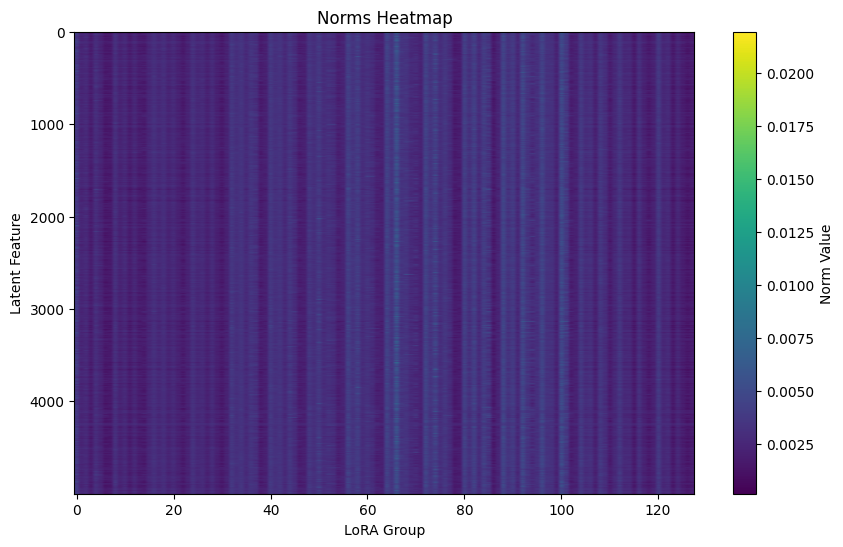

In [17]:
get_heatmap(group_indices)

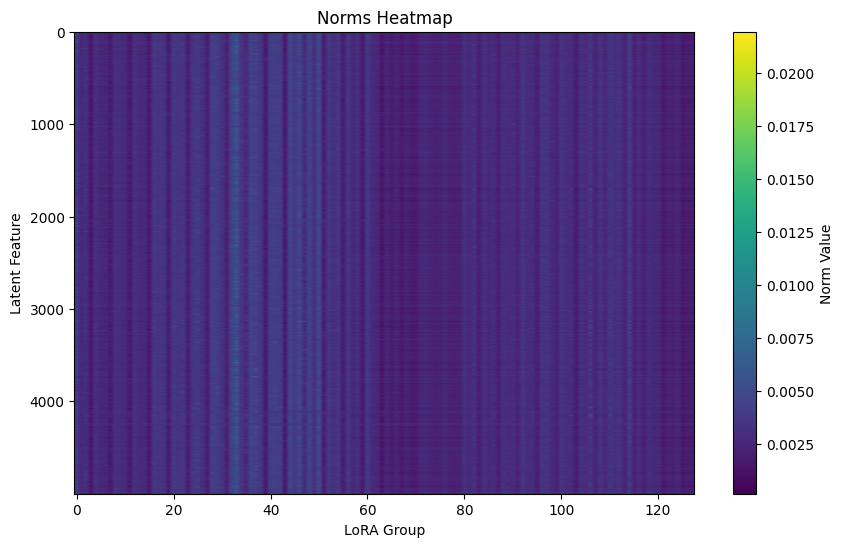

In [18]:
df = dim_df.sort_values(by=["lora_ab", "start"])
group_indices = {
    f"group_{i}": (row["start"], row["end"]) for i, row in df.iterrows()
}
get_heatmap(group_indices)
# group_indices


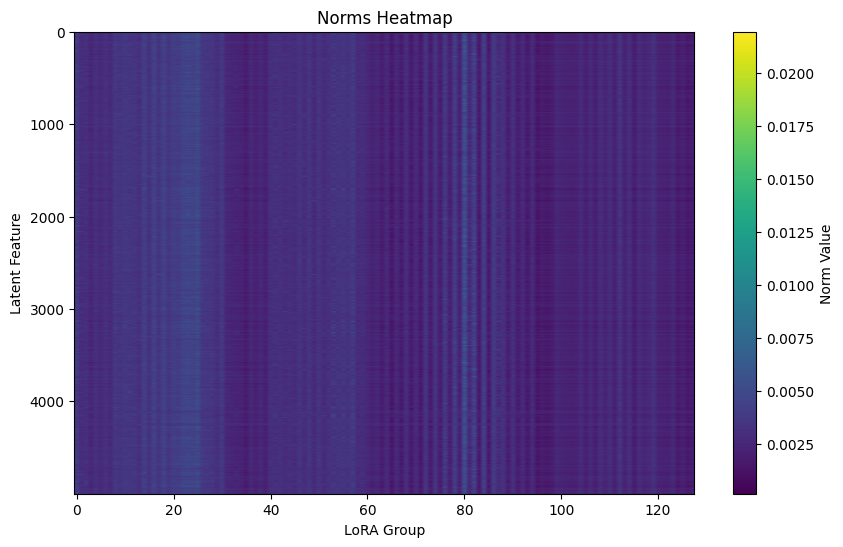

In [19]:
df = dim_df.sort_values(by=["attn_proj", "lora_ab", "start"])
group_indices = {
    f"group_{i}": (row["start"], row["end"]) for i, row in df.iterrows()
}
get_heatmap(group_indices)
# group_indices


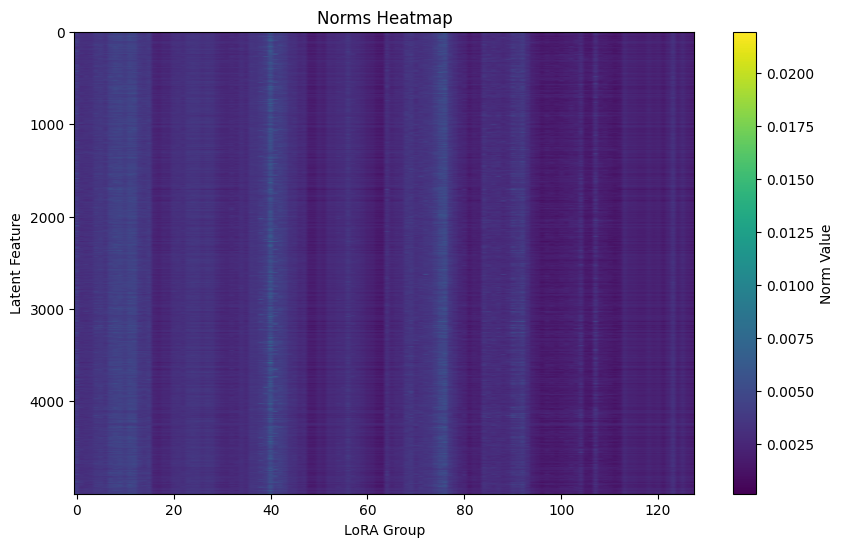

In [20]:
df = dim_df.sort_values(by=["attn_number","attn_proj", "lora_ab", "start"])
group_indices = {
    f"group_{i}": (row["start"], row["end"]) for i, row in df.iterrows()
}
get_heatmap(group_indices)
# group_indices

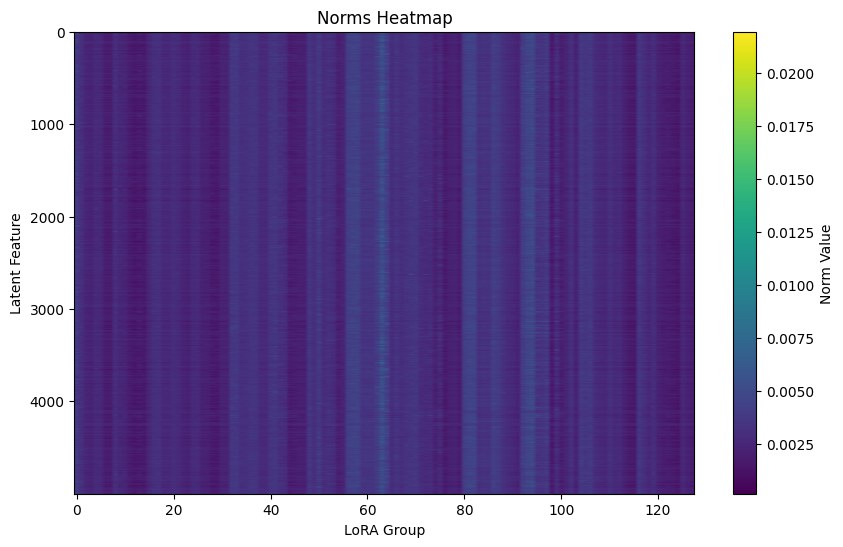

In [21]:
df = dim_df.sort_values(by=["block_type", "block_number","attn_number","attn_proj", "lora_ab", "start"])
group_indices = {
    f"group_{i}": (row["start"], row["end"]) for i, row in df.iterrows()
}
get_heatmap(group_indices)
# group_indices

In [22]:
def get_group_indices(df, group_columns):
    df = df.sort_values(by=group_columns + ["start"])
    group_indices = {}
    for group_vals, group_df in df.groupby(group_columns):
        group_name = ".".join(map(str, group_vals))  # Example: "attn_proj.lora_ab"
        indices = [(row['start'], row['end']) for _, row in group_df.iterrows()]
        group_indices[group_name] = indices
    return group_indices

In [25]:
from matplotlib.colors import LogNorm
def get_heatmap_grouped(group_indices):
    group_norms = []
    group_names = []
    for n, indices in group_indices.items():
        group_subvectors = []
        
        for start, end in indices:
            group_subvectors.append(W[:, start:end])

        concatenated_group = torch.cat(group_subvectors, dim=1)
        group_norm = concatenated_group.norm(dim=1)/(concatenated_group.shape[1] ** 0.5)
        group_norms.append(group_norm)
        group_names.append(n)

    group_norms = torch.stack(group_norms, dim=1).cpu().detach().numpy()
    plt.figure(figsize=(10, 6))
    sns.heatmap(group_norms,
                 cmap='viridis',
                #  norm=LogNorm(vmin=group_norms.min(), vmax=group_norms.max()),
                 xticklabels=group_names, cbar_kws={'label': 'Norm Value'})
    plt.yticks([])
    plt.title('Norms Heatmap')
    plt.xlabel('LoRA Group')
    plt.ylabel('Latent Feature')
    plt.show()

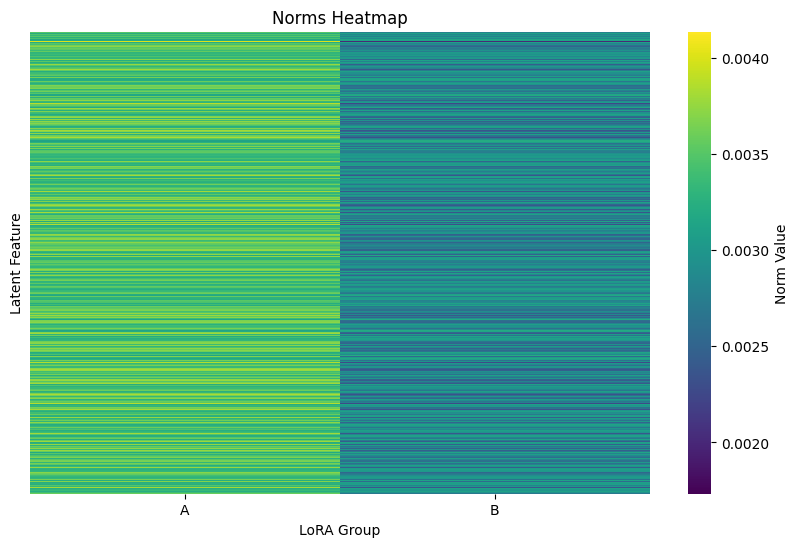

In [26]:
group_indices = get_group_indices(dim_df, ["lora_ab"])
get_heatmap_grouped(group_indices)

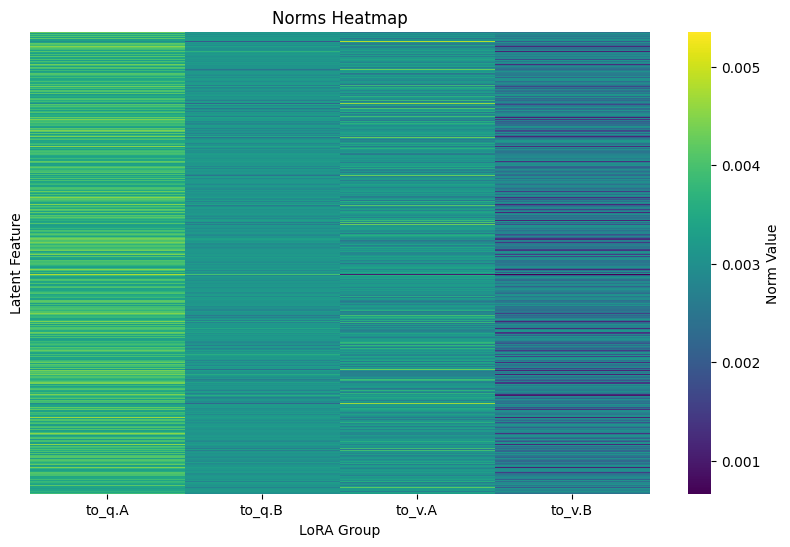

In [27]:
group_indices = get_group_indices(dim_df, ["attn_proj", "lora_ab"])
get_heatmap_grouped(group_indices)

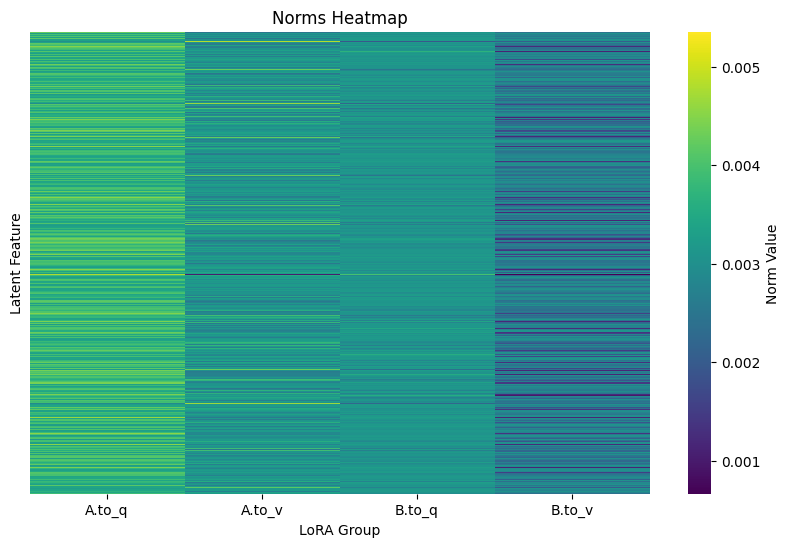

In [28]:
group_indices = get_group_indices(dim_df, ["lora_ab", "attn_proj"])
get_heatmap_grouped(group_indices)

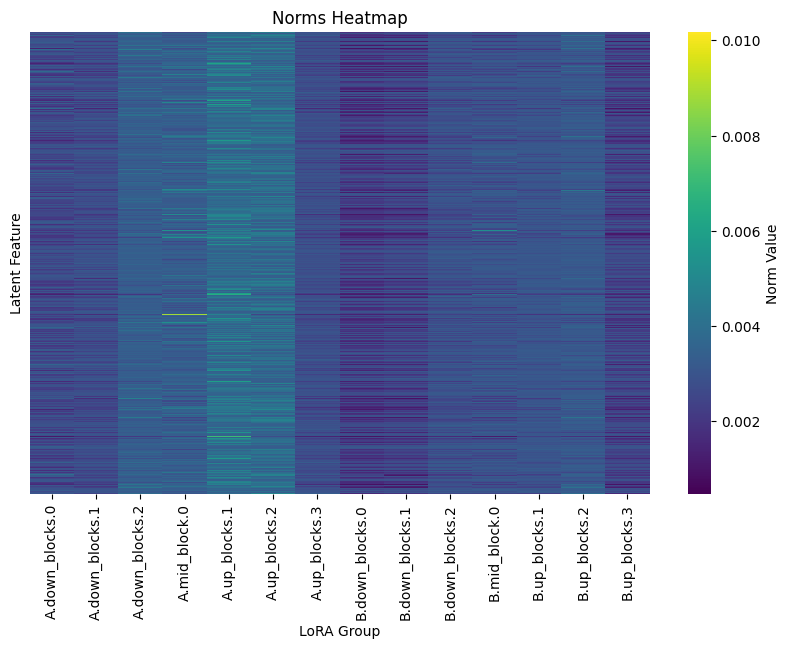

In [29]:
group_indices = get_group_indices(dim_df, ["lora_ab", "block_type","block_number"])
get_heatmap_grouped(group_indices)

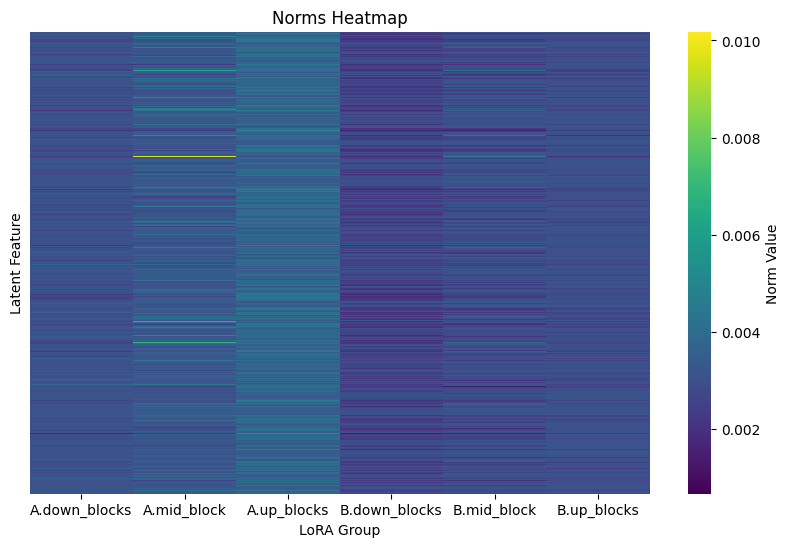

In [30]:
group_indices = get_group_indices(dim_df, ["lora_ab", "block_type"])
get_heatmap_grouped(group_indices)

In [163]:
dim_df.columns

Index([                  0,                   1,           'lengths',
                   'start',               'end',        'block_type',
            'block_number', 'attentions_number',       'attn_number',
               'attn_proj',           'lora_ab'],
      dtype='object')

### Check special feature

In [32]:
W[1479]

tensor([ 2.2217e-03,  2.2363e-03, -7.3277e-03,  ..., -9.7375e-05,
        -1.0952e-04, -3.4094e-04], device='cuda:0', grad_fn=<SelectBackward0>)

In [43]:
group_indices = get_group_indices(dim_df, ["lora_ab", "block_type","block_number","attentions_number", "attn_number", "attn_proj"])

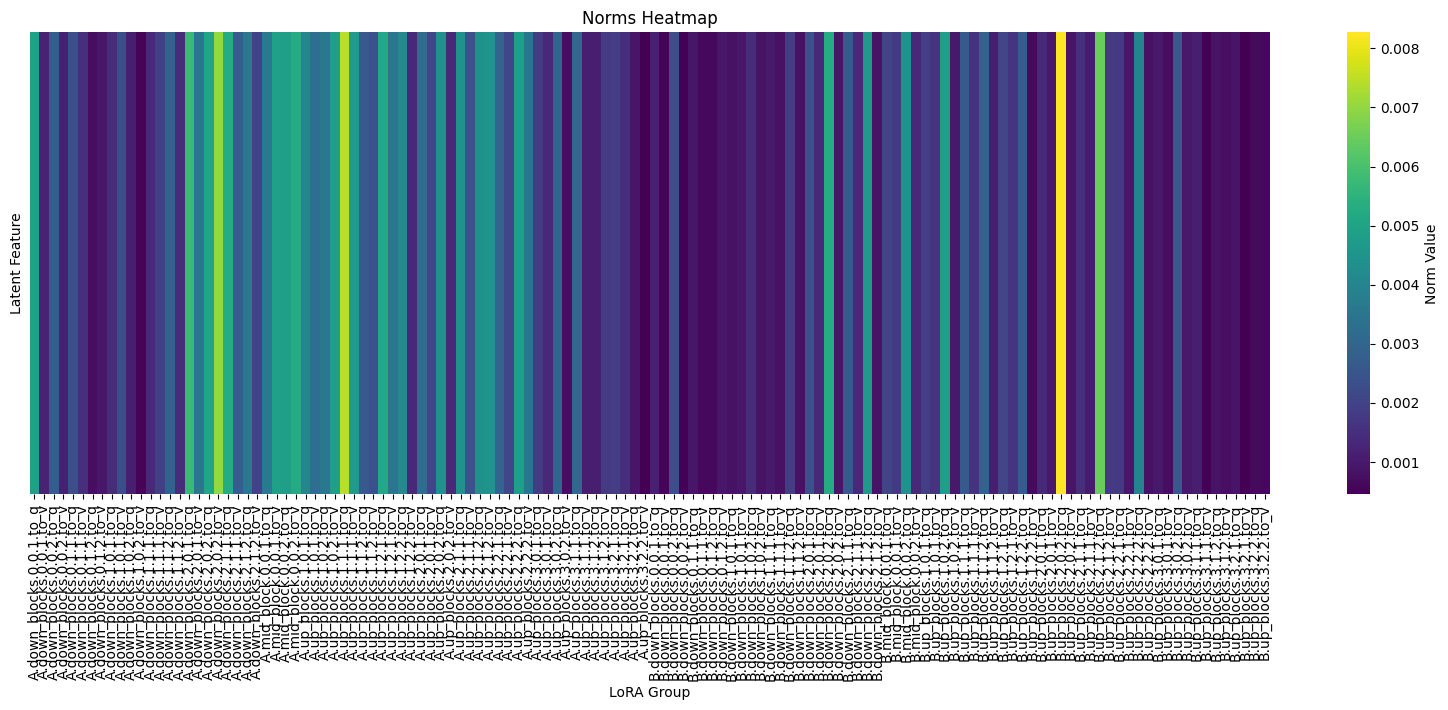

In [48]:
group_norms = []
group_names = []
for n, indices in group_indices.items():
    group_subvectors = []
    
    for start, end in indices:
        group_subvectors.append(W[1479, start:end].unsqueeze(0))

    concatenated_group = torch.cat(group_subvectors, dim=1)
    group_norm = concatenated_group.norm(dim=1)/(concatenated_group.shape[1] ** 0.5)
    group_norms.append(group_norm)
    group_names.append(n)

group_norms = torch.stack(group_norms, dim=1).cpu().detach().numpy()
plt.figure(figsize=(20, 6))
sns.heatmap(group_norms,
            cmap='viridis',
            #  norm=LogNorm(vmin=group_norms.min(), vmax=group_norms.max()),
            xticklabels=group_names, cbar_kws={'label': 'Norm Value'})
# plt.xticks(rotation=60, ha="right")
plt.yticks([])
plt.title('Norms Heatmap')
plt.xlabel('LoRA Group')
plt.ylabel('Latent Feature')
plt.show()

### Find similar to the feature

In [50]:
group_norms = []
group_names = []
for n, indices in group_indices.items():
    group_subvectors = []
    
    for start, end in indices:
        group_subvectors.append(W[:, start:end])

    concatenated_group = torch.cat(group_subvectors, dim=1)
    group_norm = concatenated_group.norm(dim=1)/(concatenated_group.shape[1] ** 0.5)
    group_norms.append(group_norm)
    group_names.append(n)

group_norms = torch.stack(group_norms, dim=1).cpu().detach().numpy()
# plt.figure(figsize=(20, 6))
# sns.heatmap(group_norms,
#             cmap='viridis',
#             #  norm=LogNorm(vmin=group_norms.min(), vmax=group_norms.max()),
#             xticklabels=group_names, cbar_kws={'label': 'Norm Value'})
# # plt.xticks(rotation=60, ha="right")
# plt.yticks([])
# plt.title('Norms Heatmap')
# plt.xlabel('LoRA Group')
# plt.ylabel('Latent Feature')
# plt.show()

In [51]:
group_norms.shape

(5000, 128)

In [66]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

row_1479 = group_norms[1479].reshape(1, -1)

similarities = cosine_similarity(group_norms, row_1479).flatten()
sorted_indices = np.argsort(similarities)[::-1][-10:] 

# distances = euclidean_distances(group_norms, row_1479).flatten()
# sorted_indices = np.argsort(distances)


sorted_matrix = group_norms[sorted_indices]

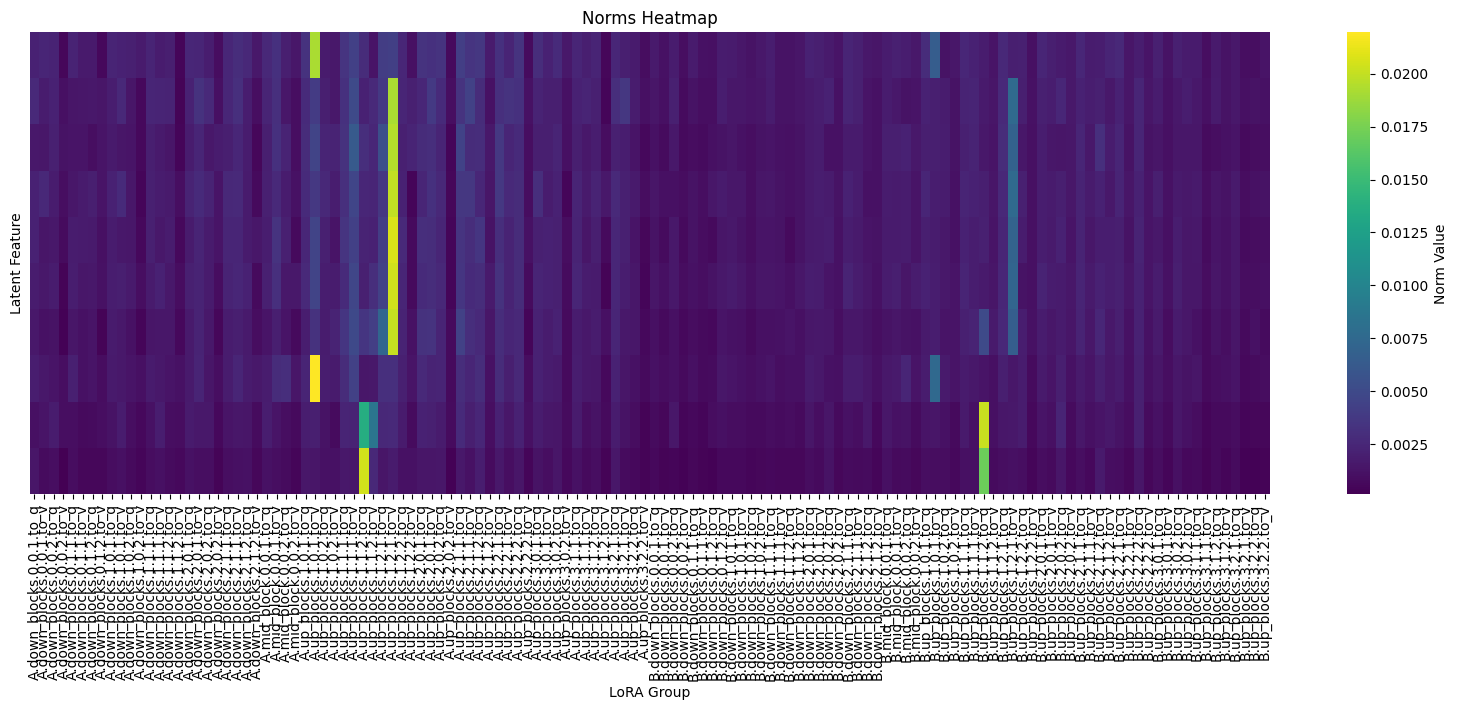

In [67]:
plt.figure(figsize=(20, 6))
sns.heatmap(sorted_matrix,
            cmap='viridis',
            #  norm=LogNorm(vmin=group_norms.min(), vmax=group_norms.max()),
            xticklabels=group_names, cbar_kws={'label': 'Norm Value'})
# plt.xticks(rotation=60, ha="right")
plt.yticks([])
plt.title('Norms Heatmap')
plt.xlabel('LoRA Group')
plt.ylabel('Latent Feature')
plt.show()

## Analyse effect of least similar features (to bushy eyebrows)

In [69]:
least_similar = np.argsort(similarities)[::-1][-10:] 
least_similar

array([ 274, 1070, 3735, 4107, 4349, 4734, 3649, 3852, 1835, 2627])

In [ ]:
blondes = torch.load(f"{path}/blondes.pt")

from sae import Sae
# sae_path = "runs/test1/0"
# sae_path = "runs/run_lat5000_bs256_auxk0.03_k1000/0"
sae_path = "runs/test_feature_logging/0"
sae = Sae.load_from_disk(sae_path,device=device)
sae.eval()

model_path = os.path.join(os.getcwd(), "base_model")
base_weights = load_file( f"{model_path}/unet/adapter_model.safetensors")

from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights

pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{model_path}/unet", adapter_name="identity1")
# adapters_weights1 = load_peft_weights(f"{model_path}/unet", device="cuda:0")
# pipe.unet.load_state_dict(adapters_weights1, strict = False)
# pipe.to(device)
# pass

generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "sks person" #"sks person in a hat in a forest"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50

## Cluster similar

In [104]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler

# Extract only sparse columns
sparse_matrix = W_half[sparse_cols, :].cpu().detach().numpy()  # Transpose to (columns, rows)\

scaler = MinMaxScaler()
W_minmax = scaler.fit_transform(sparse_matrix)

# Compute cosine similarity
# similarity = cosine_similarity(W_minmax)
similarity = euclidean_distances(W_minmax)



In [105]:
similarity.shape

(3325, 3325)

In [114]:
similarity[0].mean()

51.92753794153679

In [154]:
# Apply clustering (DBSCAN can find natural groupings)
clustering = DBSCAN(metric="precomputed", eps=50, min_samples=5).fit(similarity)

# Get cluster labels
clusters = clustering.labels_
print(f"Clustered {len(set(clusters))} groups of sparse columns.")

Clustered 1 groups of sparse columns.


In [155]:
np.bincount(abs(clustering.labels_))

array([3325])

In [77]:
similarity[1].mean()

0.9508338310136225

In [67]:
sparse_matrix[:2]

array([[ 0.007458 ,  0.000394 ,  0.001425 , ..., -0.000853 ,  0.00149  ,
         0.000697 ],
       [ 0.0113   ,  0.01226  , -0.004585 , ..., -0.0004816,  0.002407 ,
         0.001272 ]], dtype=float16)

In [45]:
7.15e-4 - 1e-4

0.000615

In [46]:
1e-3 - 7.15e-4

0.000285

## 